# **TRAINING**

In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

E0000 00:00:1738856639.684555      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0206 15:43:59.692826029      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0206 15:43:59.692841971      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0206 15:43:59.692845886      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0206 15:43:59.692848744      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0206 15:43:59.692851441      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## **DISTRIBUTION DEFINITIONS**

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1738856676.385591      13 service.cc:145] XLA service 0x57e8a43e3480 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738856676.385640      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1738856676.385644      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1738856676.385647      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1738856676.385650      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1738856676.385653      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1738856676.385656      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1738856676.385658      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1738856676.385661      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256


## **DATA PREPROCESSING**

In [6]:
# LOAD OF DATA SET
data_test = np.load('/kaggle/input/lung-cancer/segmented_train_set.npz', allow_pickle=True)
print(data_test)

X_segmented = data_test['segmented_full_slices']
y_full = data_test['labels']


print(X_segmented.shape)
print(y_full.shape)

NpzFile '/kaggle/input/lung-cancer/segmented_train_set.npz' with keys: full_slices, nodules, labels, masks, segmented_full_slices
(3089, 512, 512, 3)
(3089,)


In [7]:
from sklearn.model_selection import train_test_split

y_full = y_full <= 3
y_full = y_full.reshape(-1, 1)

print(y_full.shape)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_segmented, y_full, stratify=y_full, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3089, 1)
(2471, 512, 512, 3) (2471, 1)
(309, 512, 512, 3) (309, 1)
(309, 512, 512, 3) (309, 1)


In [8]:
def plot_image(img, num_images = 30, images_per_row = 10):
    list_numer = list(range(0, img.shape[0]))
    
    # Randomly select image keys
    selected_keys = random.sample(list_numer, num_images)
    
    # Calculate the number of rows needed
    num_rows = int(np.ceil(num_images / images_per_row))
    
    # Create the figure with the appropriate dimensions
    plt.figure(figsize=(20, 4 * num_rows))
    
    for idx, key in enumerate(selected_keys):
        plt.subplot(num_rows, images_per_row, idx + 1)
        plt.imshow(img[key], cmap='gray')
        plt.axis('off')
        plt.title(f'Image {idx + 1}')
    

    plt.tight_layout()
    plt.show()

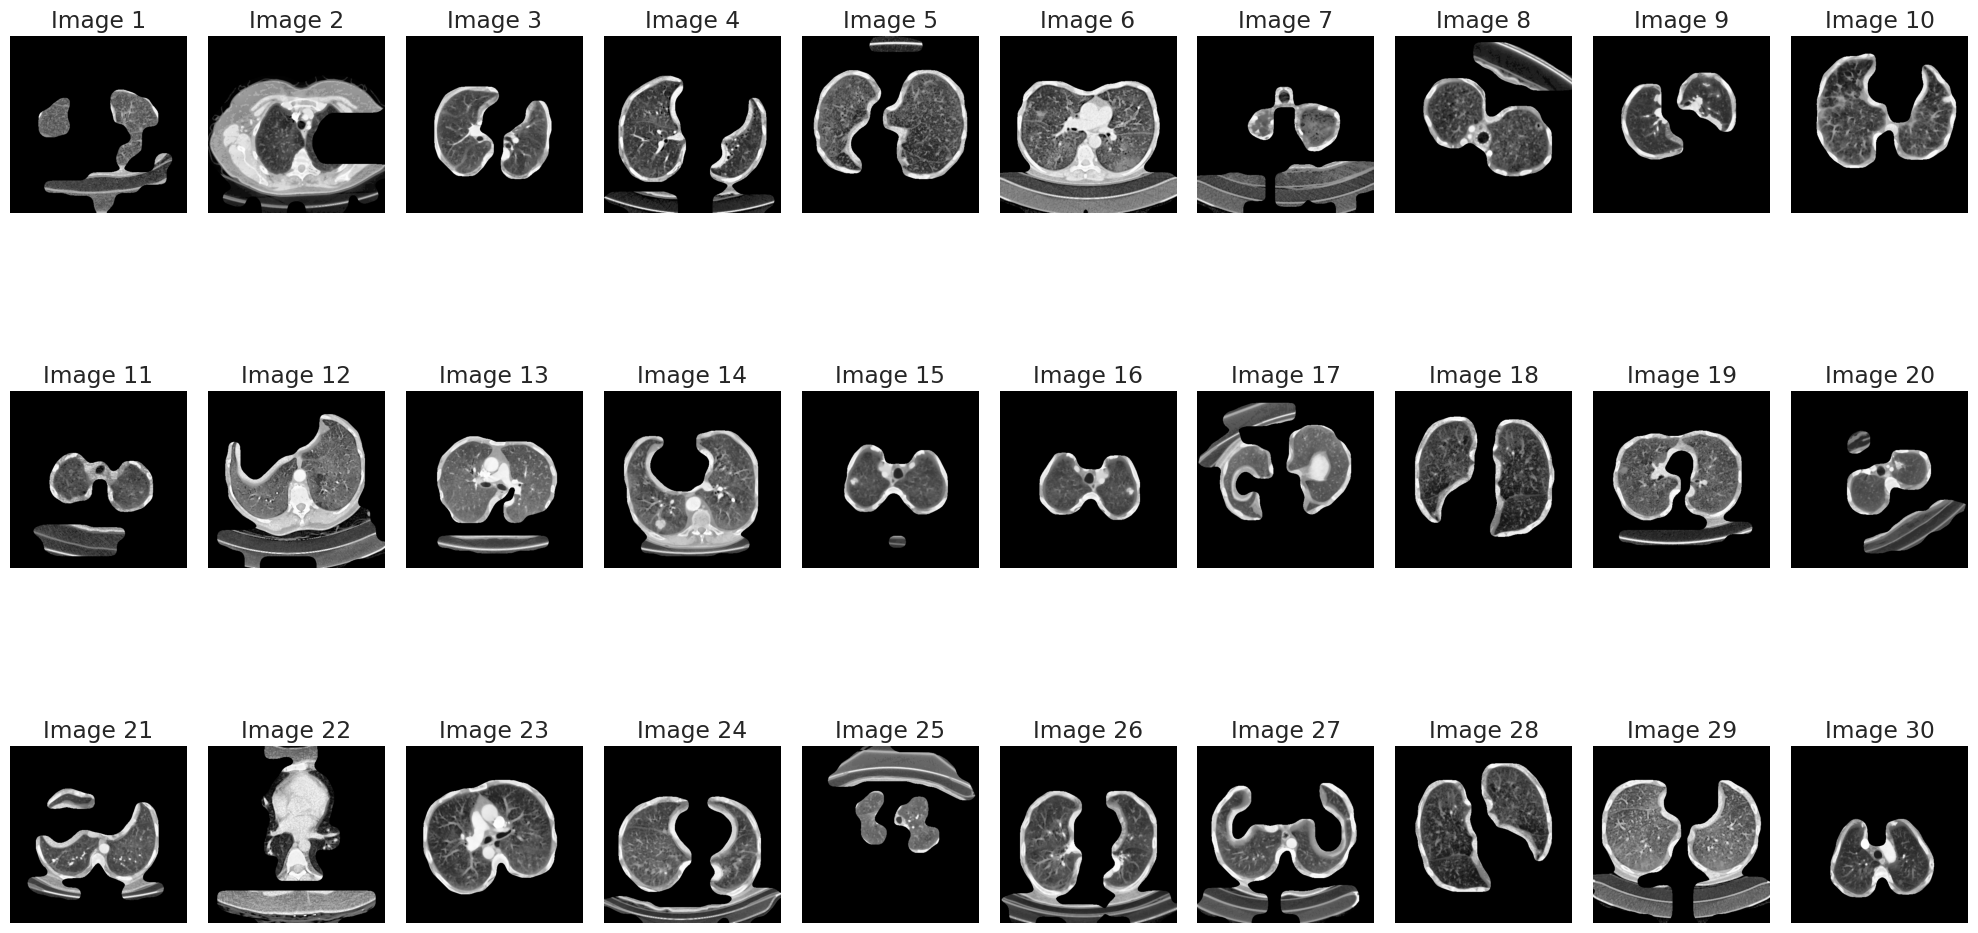

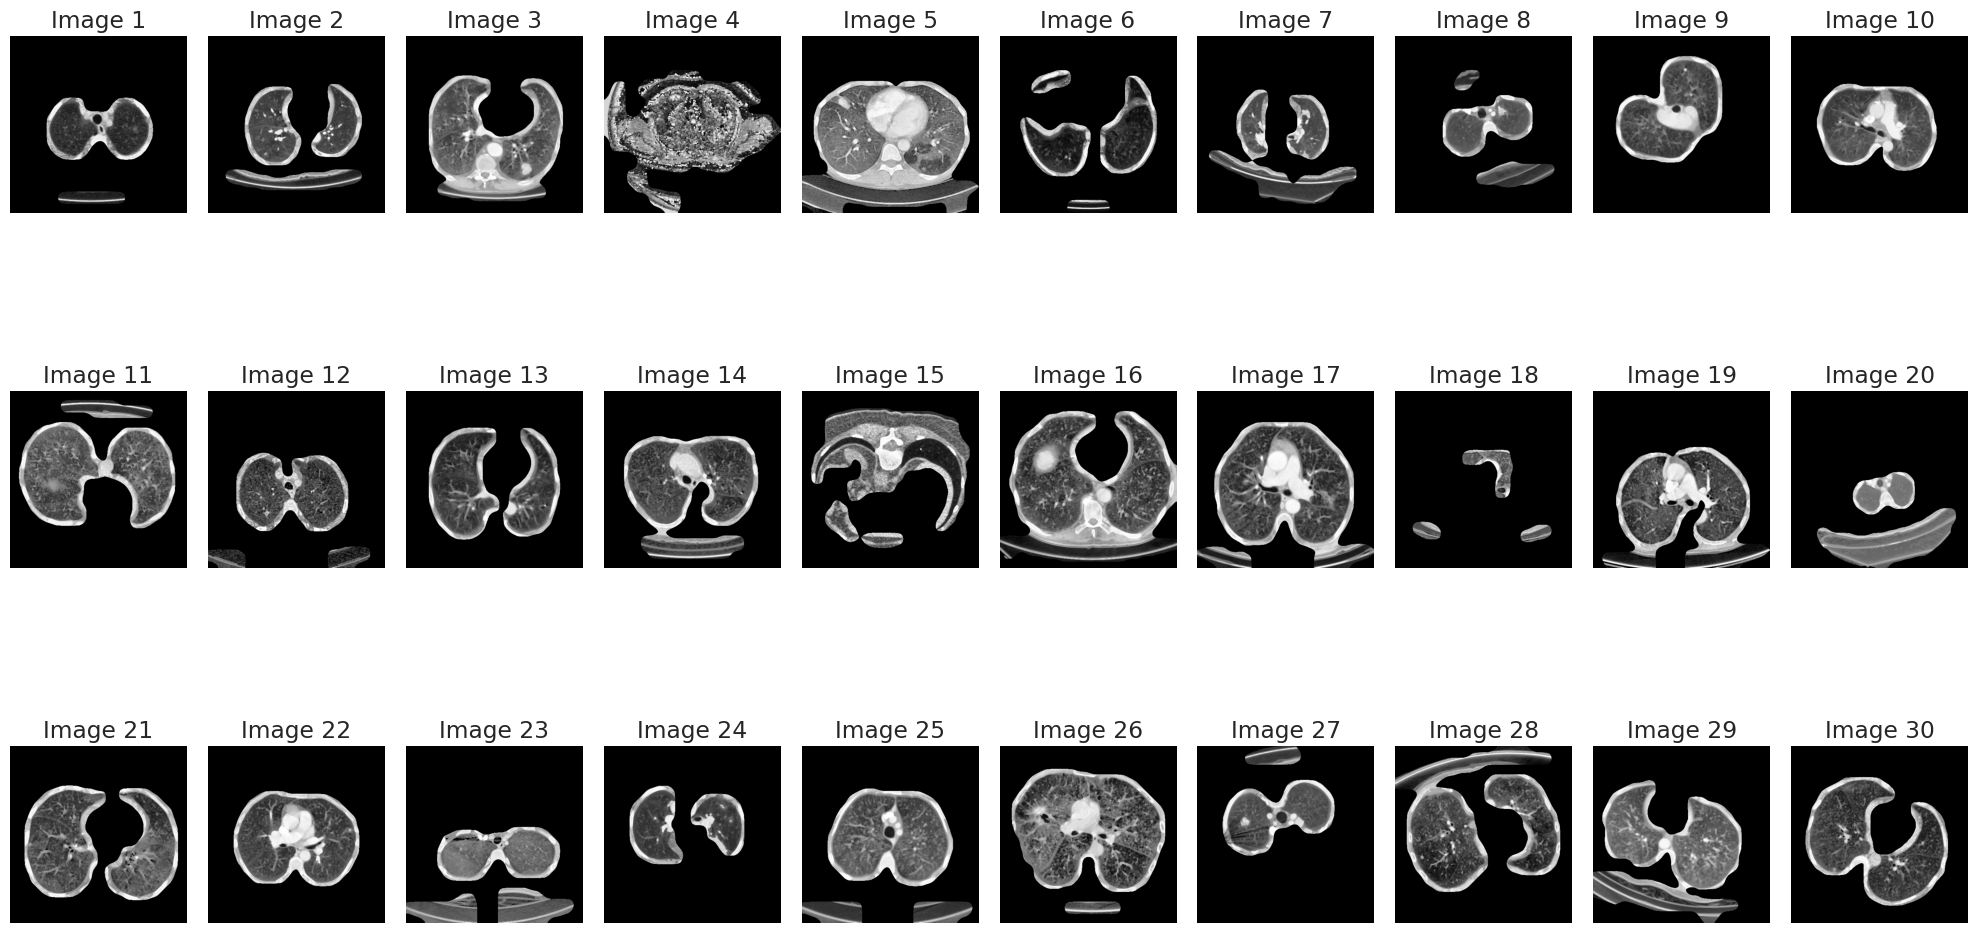

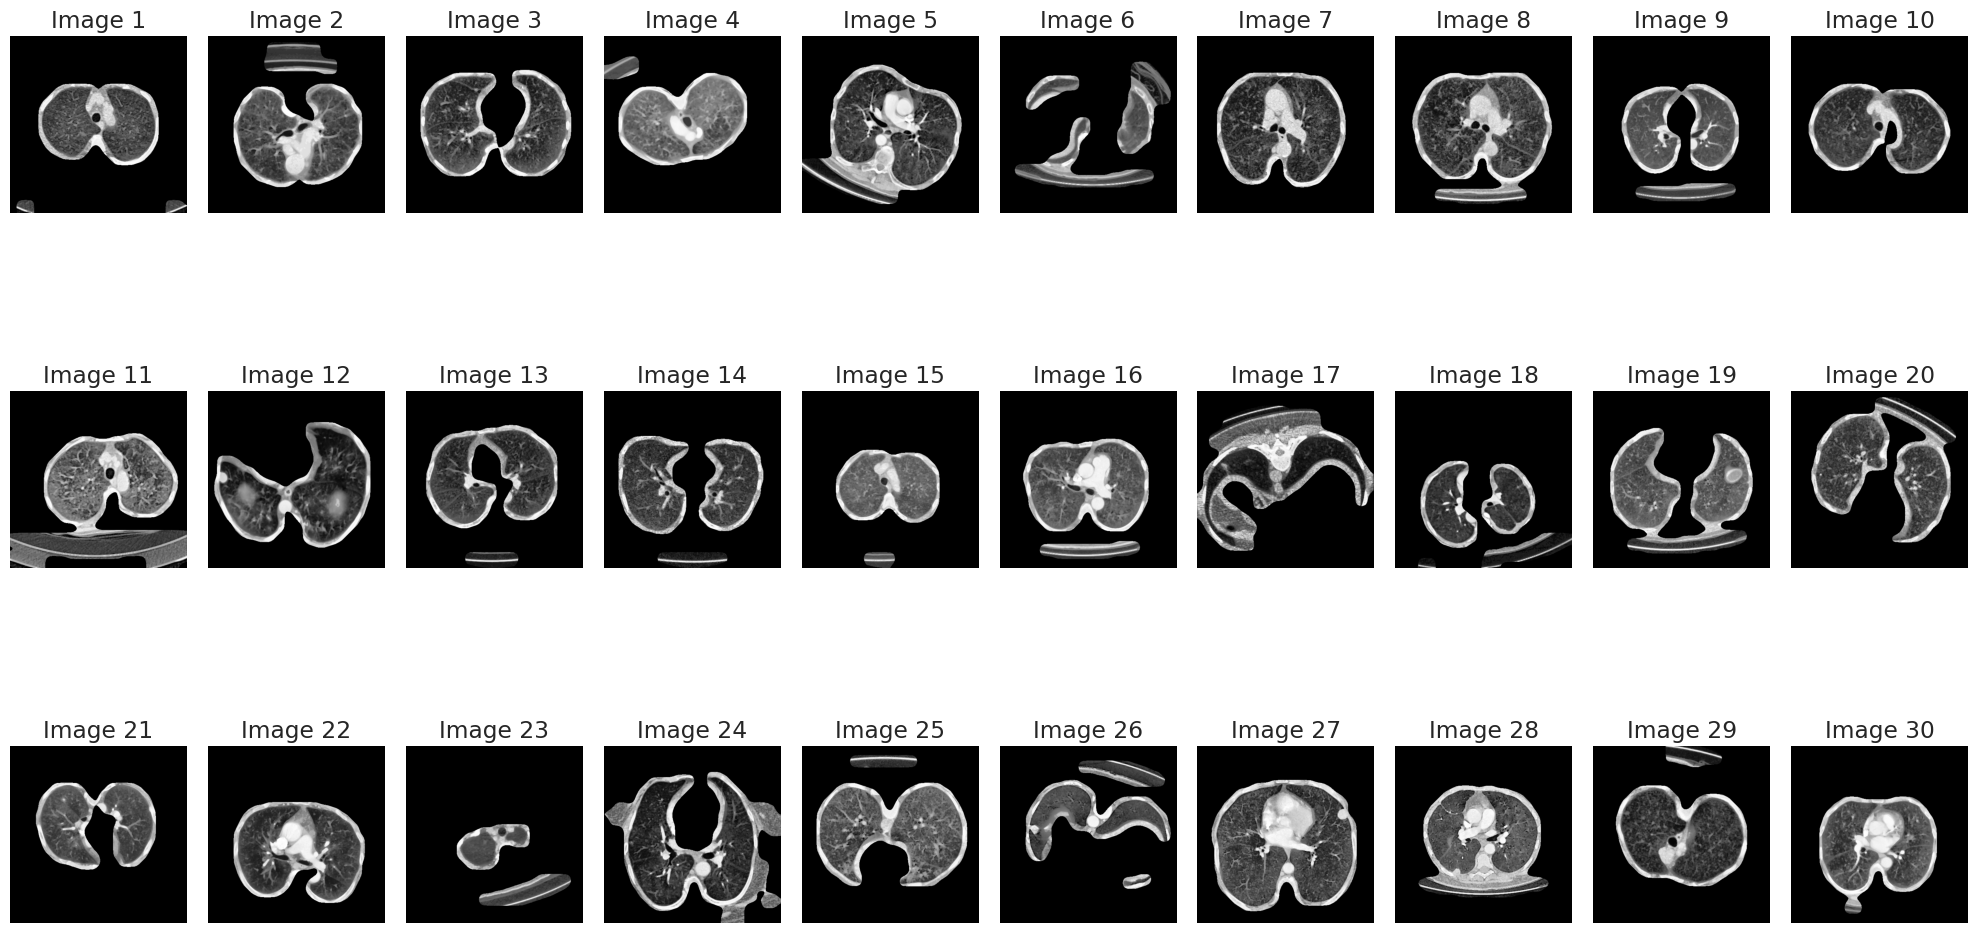

In [9]:
plot_image(X_train)
plot_image(X_val)
plot_image(X_test)

In [10]:
# print(X_train[0])
# min = np.min(X_train)
# max = np.max(X_train)

# print(min, max)

def preprocess_data(X):
    # Normalizza le immagini
    X = X.astype('float32') / 255.0
    
    return X

# Applica il preprocessing ai dati
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)
X_test = preprocess_data(X_test)

# min = np.min(X_train)
# max = np.max(X_train)

# print(min, max)

In [11]:
count_true = np.sum(y_train == True) 
count_false = np.sum(y_train == False)

print(count_true, count_false)

1618 853


In [12]:
def compute_class_weights(y):
    # Calculate the weights inversely proportional to the frequency
    
    class_counts = np.bincount(y.flatten())
    total = len(y)
    weights = total / (len(class_counts) * class_counts)
    return dict(enumerate(weights))

weights = compute_class_weights(y_train)
print(weights)

{0: 1.4484173505275497, 1: 0.7635970333745364}


In [13]:
# Number of training epochs
epochs = 1000

# Learning rate: step size for updating the model's weights
learning_rate = 1e-3

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 256
Learning Rare: 0.001


In [14]:
X_train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2000).batch(batch_size)
X_train_df = X_train_df.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

X_val_df = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(2000).batch(batch_size)
X_val_df = X_val_df.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [15]:
seed = 42
from tensorflow.keras import layers
from tensorflow.keras import layers as tfkl
from tensorflow.keras import optimizers as op
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications.convnext import preprocess_input

def build_model(
    input_shape,
    output_shape,
    learning_rate = learning_rate,
    seed=seed
):

    heNormal = HeNormal(seed=seed)

    inputs = tfkl.Input(shape=input_shape, name='Input',  batch_size=1)
    input_proces = preprocess_input(inputs)

    # Download the ResNet50 Model
    base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=input_proces)


    base_model.trainable = True

    number_layers = len(base_model.layers)
    print("number_layers: ", number_layers)

    non_trainble_layers = int(0.5 * number_layers)
    print("non_trainble_layers: ", non_trainble_layers)

    for layer in base_model.layers[:non_trainble_layers]:
        layer.trainable = False



    # We have blocked BatchNormalization layer to mantain the statistical variables
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False



    x = layers.GlobalAveragePooling2D(name='gap')(base_model.output)
    
    
    # DROPOUT
    #x = tfkl.Dense(1024, activation='relu', kernel_initializer=heNormal)(x)
    #x = tfkl.Dropout(0.3)(x)


    # OUTPUT LAYER CLASSIFICATION
    outputs = tfkl.Dense(units=output_shape, name='dense_output', activation = 'sigmoid')(x)

    final_model = tfk.Model(inputs=inputs, outputs=outputs, name='ConvNeXtBase')


    # Compile the model
    loss = tfk.losses.BinaryCrossentropy()


    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']


    final_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


    return final_model

In [16]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [17]:
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [18]:
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/checkpoint_Conv.keras', verbose=1, save_best_only=True)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',     # Monitor the loss on the validation set.
#     factor=0.5,             # Reduces LR by a factor of 0.5 (halves it).
#     patience=5,            # Wait 10 epochs with no improvements before reducing the LR.
#     min_delta=1e-4,         # Only consider improvements > 0.0001.
#     min_lr=1e-7            # Does not reduce LR below 1e-6.
# )

lr_reducer = CustomReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)

# Store the callback in a list
callbacks = [early_stopping, lr_reducer, RealTimePlot()]

In [19]:
# Train the model with early stopping callback
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]
print(y_train.shape)

with strategy.scope():
    final_model = build_model(input_shape=input_shape, output_shape=output_shape)

(2471, 1)


I0000 00:00:1738856716.717697      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
number_layers:  259
non_trainble_layers:  129


In [20]:
from tensorflow.keras import utils as ut

final_model.summary(expand_nested=True)

# ut.plot_model(final_model, expand_nested=False, show_trainable=True, show_shapes=True, dpi=60)

Model: "ConvNeXtBase"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (1, 512, 512, 3)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (1, 512, 512, 3)  │          0 │ Input[0][0]       │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (1, 128, 128,     │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (1, 128, 128,     │      6,272 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (1, 128, 128,     │        256 │ -                 │
│ convnext_base_stem… │ 128)              │            │                   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 128, 128,     │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │      6,400 │ add[0][0]         │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (1, 128, 128,     │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 87,567,489 (334.04 MB)

 Trainable params: 59,349,505 (226.40 MB)

 Non-trainable params: 28,217,984 (107.64 MB)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2471, 512, 512, 3)
(2471, 1)
(309, 512, 512, 3)
(309, 1)


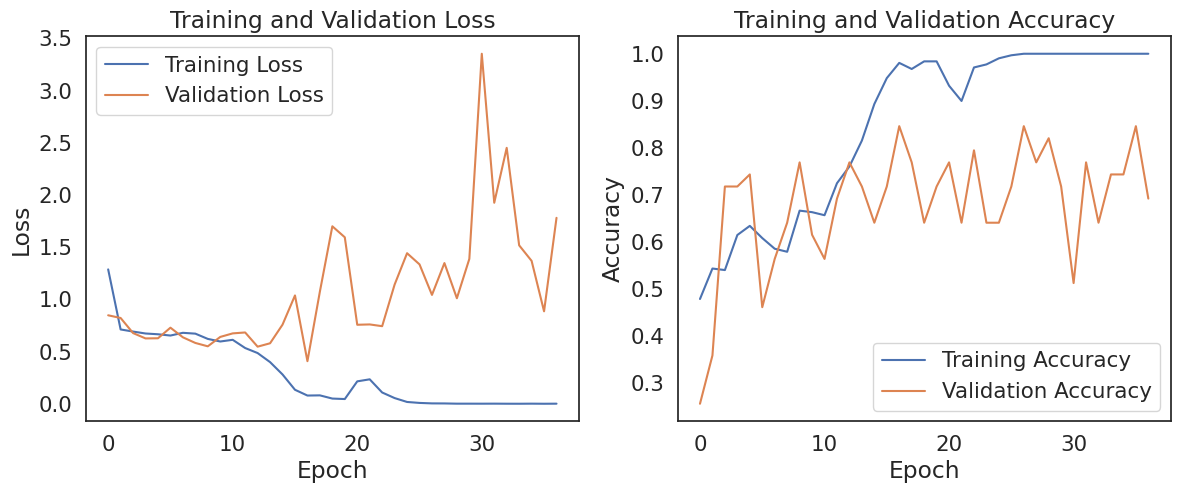

10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.6923 - val_loss: 1.7805


In [22]:
history = final_model.fit(
    X_train_df,
    epochs=epochs,
    validation_data=(X_val_df),
    callbacks=callbacks,
    class_weight=weights
).history

In [23]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

import datetime
now = datetime.datetime.now()

# Format as Day-Month-HH:min
date_time_str = now.strftime("%d-%m-%H:%M")


with strategy.scope():
    model_filename = './ConvBase_accuracy_f1_score_'+str(final_val_accuracy)+'_'+date_time_str+'.keras'
    final_model.save(model_filename)

Final validation accuracy: 84.62%


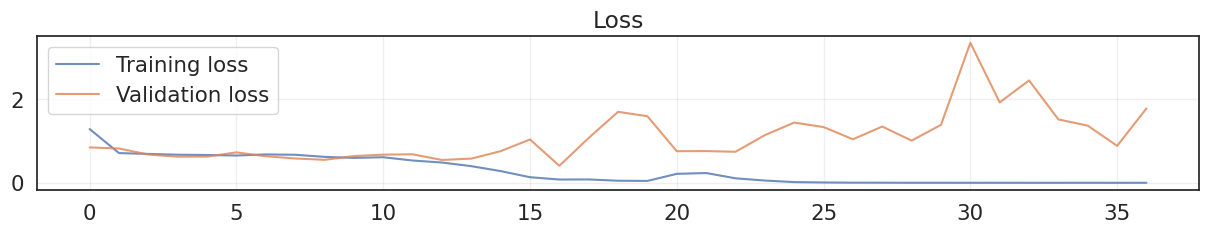

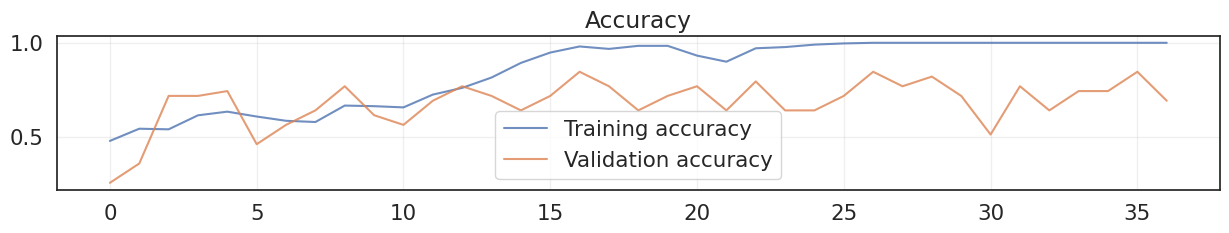

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [25]:
# Predict labels for the entire test set
predictions = final_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

2025-02-06 16:04:14.130773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node ConvNeXtBase_1/convnext_base_downsampling_block_0_1/convnext_base_downsampling_conv_0_1/Reshape/ReadVariableOp.
I0000 00:00:1738857854.630541     774 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8407f96e0739c9f6:0:0), session_name()
I0000 00:00:1738857861.340616     774 tpu_compile_op_common.cc:245] Compilation of 8407f96e0739c9f6:0:0 with session name  took 6.7100273s and succeeded
I0000 00:00:1738857861.365937     774 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8407f96e0739c9f6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11261837667475937063", property.function_library_fingerprint = 8911500639053869493, property.mlir_module_fingerprint = 0, property.num_replica

Predictions Shape: (309, 1)


In [26]:
predictions = predictions >= 0.5

Accuracy score over the test set: 0.754
Precision score over the test set: 0.7465
Recall score over the test set: 0.754
F1 score over the test set: 0.7452


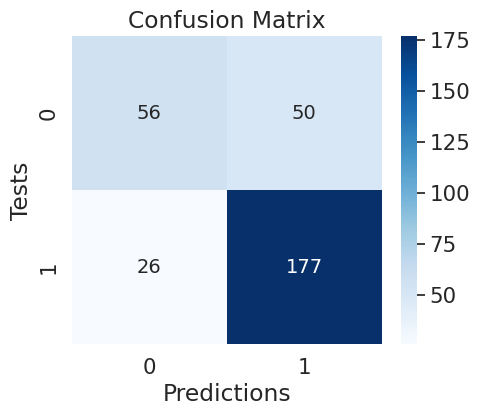

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Calculate and display test set accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(y_test, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(y_test, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Combine numbers and percentages into a single string for annotation
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('Tests')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import seaborn as sns

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    
    y_pred_proba = model.predict(X_test)

    y_pred_proba = y_pred_proba[:, 0]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")
    
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random classifier')
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return roc_auc

def analyze_thresholds(model, X_test, y_test, n_thresholds=10):
    
    y_pred_proba = model.predict(X_test)

    y_pred_proba = y_pred_proba[:, 0]
    
    thresholds = np.linspace(0.1, 0.9, n_thresholds)
    
    results = []
    for threshold in thresholds:
        
        y_pred = (y_pred_proba >= threshold).astype(int)
        
       
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy':  accuracy
        })
    
    return pd.DataFrame(results)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


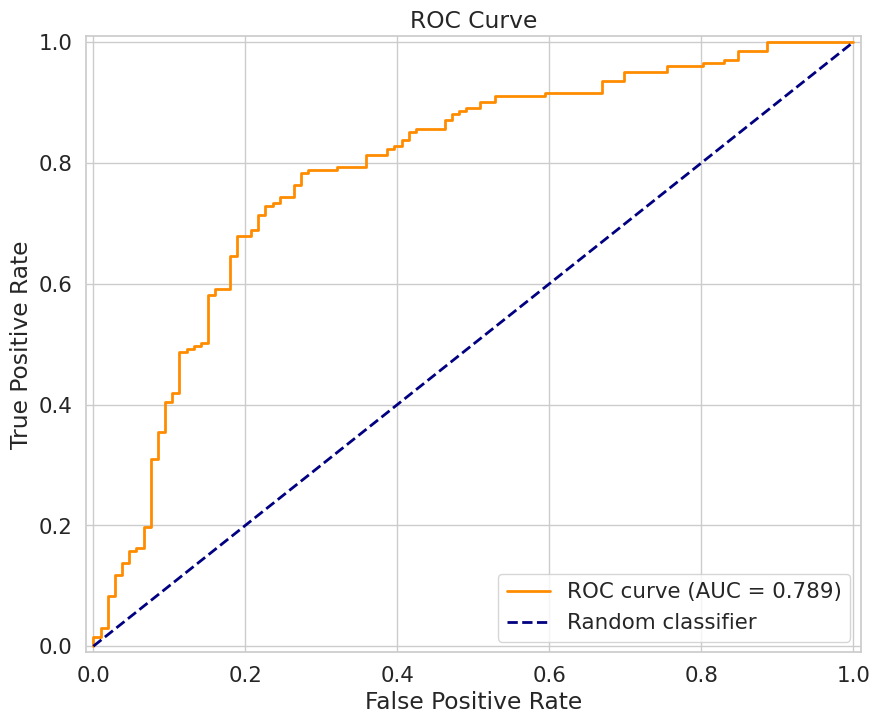

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step

Analisi delle soglie:
   threshold  precision    recall  f1_score  accuracy
0   0.100000   0.748988  0.911330  0.822222  0.741100
1   0.188889   0.767635  0.911330  0.833333  0.760518
2   0.277778   0.772152  0.901478  0.831818  0.760518
3   0.366667   0.771186  0.896552  0.829157  0.757282
4   0.455556   0.781659  0.881773  0.828704  0.760518
5   0.544444   0.782222  0.866995  0.822430  0.754045
6   0.633333   0.794521  0.857143  0.824645  0.760518
7   0.722222   0.798122  0.837438  0.817308  0.754045
8   0.811111   0.802885  0.822660  0.812652  0.750809
9   0.900000   0.809045  0.793103  0.800995  0.741100


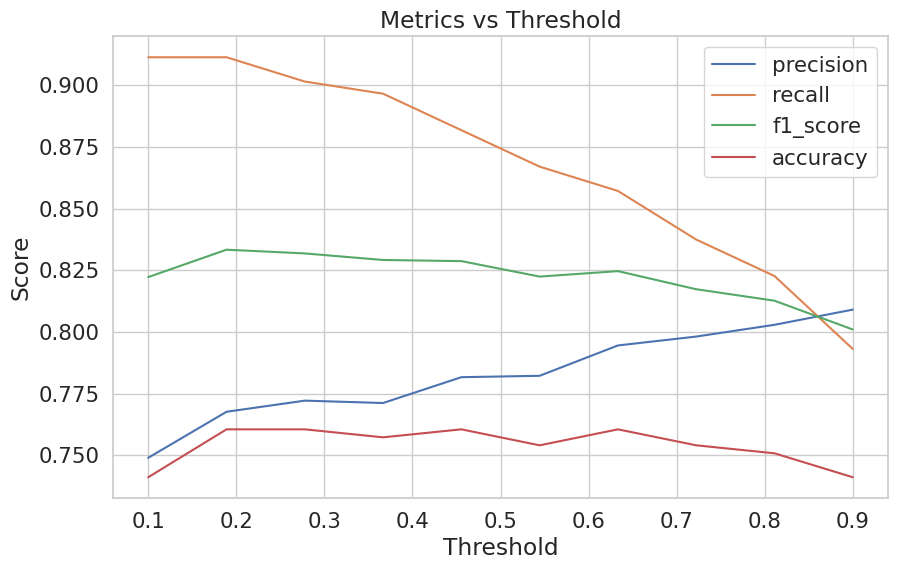

In [29]:

auc_score = plot_roc_curve(final_model, X_test, y_test)
plt.show()
    

threshold_analysis = analyze_thresholds(final_model, X_test, y_test)
print("\nAnalisi delle soglie:")
print(threshold_analysis)
    

plt.figure(figsize=(10, 6))
for metric in ['precision', 'recall', 'f1_score', 'accuracy']:
    plt.plot(threshold_analysis['threshold'], 
                threshold_analysis[metric], 
                label=metric)
    
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()